# Multi Label Classification: Auto Tagging


Importing required Libraries


In [1]:
import re

import joblib
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk import WordNetLemmatizer, word_tokenize, FreqDist
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import (
    jaccard_score,
    hamming_loss,
    accuracy_score,
    classification_report,
)
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

Loading Dataset


In [2]:
dataset = pd.read_excel("Sample_AutoTagging_Data_Confidential.xlsx")
dataset

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
0,Climate risk and response: Physical hazards an...,Risk & Resilience|Strategy & Corporate Finance...,Sustainability - Climate & ESG Mgmt|Government...
1,New Accenture Research Finds Leaders and Emplo...,Organization,Talent|Culture & transformational change
2,"Me, my life, my wallet - The widespread and im...","Growth, Marketing & Sales",Customer experience
3,The next normal arrives: Trends that will defi...,Public And Social Sector|Risk & Resilience|Gro...,Economic development|Crisis Preparedness and R...
4,Our 2021 technology predictions for businesses...,McKinsey Technology|Organization,Tech strategy & operating model & agile|Leader...
...,...,...,...
19995,How to reshape aerospace and defence supply ch...,Aerospace & Defense|Operations|Risk & Resilience,Aerospace & Defense- Other|Manufacturing & sup...
19996,Why current challenges make a more sustainable...,Banking,Retail banking|Consumer Credit
19997,What companies should consider when making cli...,Strategy & Corporate Finance|Sustainability,CFO-Finance-Capital Markets|Sustainability inv...
19998,Post-Brexit trade: Navigating the disruption -...,Operations,Operations- Other


Dataset Information


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SUMMARY        20000 non-null  object
 1   PRACTICE/AREA  20000 non-null  object
 2   SL/SUB-AREA    20000 non-null  object
dtypes: object(3)
memory usage: 468.9+ KB


Dataset Statistics


In [4]:
dataset.describe()

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
count,20000,20000,20000
unique,19985,5910,12637
top,Survey: US consumer sentiment during the coron...,Organization,Economic development
freq,3,1034,347


### Data-Preprocessing


In [5]:
X_train_1, X_test_1, y_train_1, y_test_1, y_train_2, y_test_2 = train_test_split(
    dataset["SUMMARY"],
    dataset["PRACTICE/AREA"],
    dataset["SL/SUB-AREA"],
    test_size=0.1,
    random_state=41,
)

In [6]:
testingDataset = pd.concat([X_test_1, y_test_1], axis=1)
testingDataset.reset_index(drop=True, inplace=True)
testingDataset.head()

,SUMMARY,PRACTICE/AREA
0,Infrastructure trends - Since the onset of the...,Public And Social Sector|Operations|Sustainabi...
1,Failure is not an option: Increasing the chanc...,Sustainability|Organization
2,Cautiously optimistic: Chinese consumer behavi...,"Consumer Goods|Growth, Marketing & Sales|Digit..."
3,Three ways health insurers can reimagine partn...,Healthcare|Strategy & Corporate Finance|Operat...
4,Visualizing your journey - The cloud can eat a...,McKinsey Technology|Public And Social Sector|T...


In [7]:
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

In [8]:
lemmatizer = WordNetLemmatizer()


def preprocess_text(document):
    document = document.lower()
    # Remove punctuation and numbers
    document = re.sub(r"[^\w\s]", "", document)
    document = re.sub(r"\d+", "", document)
    tokens = word_tokenize(document)
    tokens = list(set(tokens))
    # Remove stopwords, Lemmatize, and then rejoin the words
    wordsLemmatized = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in set(stopwords.words("english"))
    ]
    document = " ".join(wordsLemmatized)
    return document

In [9]:
X_train_1 = X_train_1.apply(preprocess_text)
X_test_1 = X_test_1.apply(preprocess_text)

In [10]:
X_train_1.head()

3065     economy already plummeting economic world seco...
2672     encouraging working early day domain reality n...
14299    seen comment cbis high supporting lockdown eco...
469      recovery used already largest healthrelevant p...
61       road achieve consumer massmarket ahead emobili...
Name: SUMMARY, dtype: object

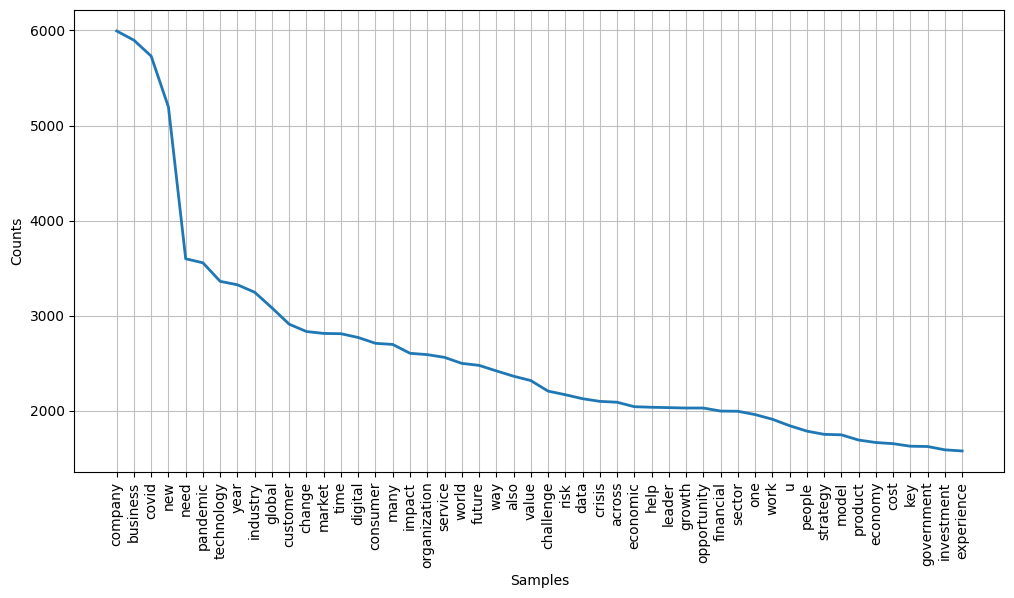

Total Words Count:  840500


In [11]:
corpus = " ".join(X_train_1)

tokens = nltk.word_tokenize(corpus)
fdist = FreqDist(tokens)

plt.figure(figsize=(12, 6))
fdist.plot(50, cumulative=False)
plt.show()
print("Total Words Count: ", len(tokens))

In [12]:
y_train_1 = y_train_1.str.split("|")
y_test_1 = y_test_1.str.split("|")

y_train_1.head()

3065     [Strategy & Corporate Finance, Risk & Resilien...
2672     [McKinsey Technology, Telecom, Media & Technol...
14299                   [Public And Social Sector, Retail]
469      [Strategy & Corporate Finance, Organization, G...
61                 [Automotive, Growth, Marketing & Sales]
Name: PRACTICE/AREA, dtype: object

In [14]:
mlb = MultiLabelBinarizer()
y_train_1 = mlb.fit_transform(y_train_1)
y_test_1 = mlb.transform(y_test_1)
y_train_1 = pd.DataFrame(y_train_1, columns=mlb.classes_)
y_test_1 = pd.DataFrame(y_test_1, columns=mlb.classes_)
joblib.dump(mlb, "mlb1.joblib")
y_train_1.head()

,Advanced Electronics,Aerospace & Defense,Agriculture,Automotive,Banking,Basic Materials,Business & Consumer Services,Chemicals,Consumer Goods,Digital & Analytics (DnA),...,Private Equity,Public And Social Sector,Public and Social Sector,Retail,Risk & Resilience,Risk & resilience,Strategy & Corporate Finance,Sustainability,"Telecom, Media & Technology","Travel, Logistics & Infrastructure"
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
tag_counts = y_train_1.sum(numeric_only=True) + y_test_1.sum(numeric_only=True)
print("Label Count: ", tag_counts.shape[0], "\n", tag_counts)

Label Count:  34 
 Advanced Electronics                   277
Aerospace & Defense                    188
Agriculture                            132
Automotive                             689
Banking                               2551
Basic Materials                        323
Business & Consumer Services           118
Chemicals                              142
Consumer Goods                         842
Digital & Analytics (DnA)             6009
Energy                                 776
Environment, Water & Waste             129
Growth, Marketing & Sales             3741
Healthcare                            1128
Insurance                              802
McKinsey Technology                   3826
McKinsey Transformation                  2
Mckinsey Transformation                 78
Medical Products                       155
Operations                            2623
Ops-Capital Excellence                  38
Organization                          6618
People & Org Performance (POP)     

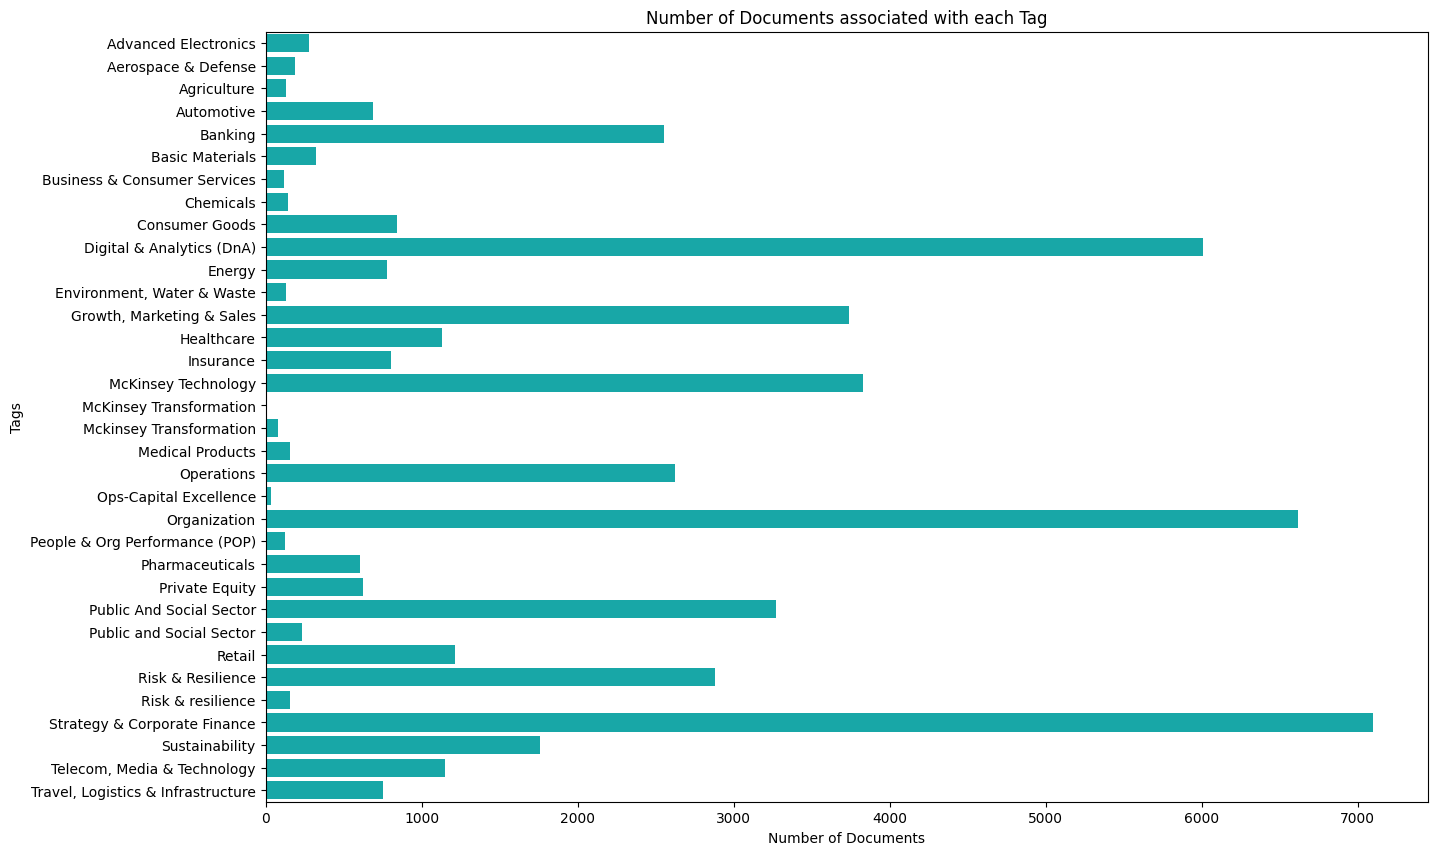

In [16]:
plt.figure(figsize=(15, 10))
sns.barplot(x=tag_counts.values, y=tag_counts.index, color="c")
plt.xlabel("Number of Documents")
plt.ylabel("Tags")
plt.title("Number of Documents associated with each Tag")
plt.show()

In [17]:
def drop_labels(y_train, y_test):
    tag_counts = y_train.sum(numeric_only=True) + y_test.sum(numeric_only=True)
    labels_to_drop = tag_counts = tag_counts[tag_counts < 100].index
    y_train = y_train.drop(labels_to_drop, axis=1)
    y_test = y_test.drop(labels_to_drop, axis=1)
    return y_train, y_test

In [18]:
y_train_1_, y_test_1_ = drop_labels(y_train_1, y_test_1)
tag_counts_ = y_train_1_.sum(numeric_only=True) + y_test_1_.sum(numeric_only=True)
print("Label Count: ", tag_counts_.shape[0], "\n", tag_counts_)

Label Count:  31 
 Advanced Electronics                   277
Aerospace & Defense                    188
Agriculture                            132
Automotive                             689
Banking                               2551
Basic Materials                        323
Business & Consumer Services           118
Chemicals                              142
Consumer Goods                         842
Digital & Analytics (DnA)             6009
Energy                                 776
Environment, Water & Waste             129
Growth, Marketing & Sales             3741
Healthcare                            1128
Insurance                              802
McKinsey Technology                   3826
Medical Products                       155
Operations                            2623
Organization                          6618
People & Org Performance (POP)         127
Pharmaceuticals                        608
Private Equity                         622
Public And Social Sector           

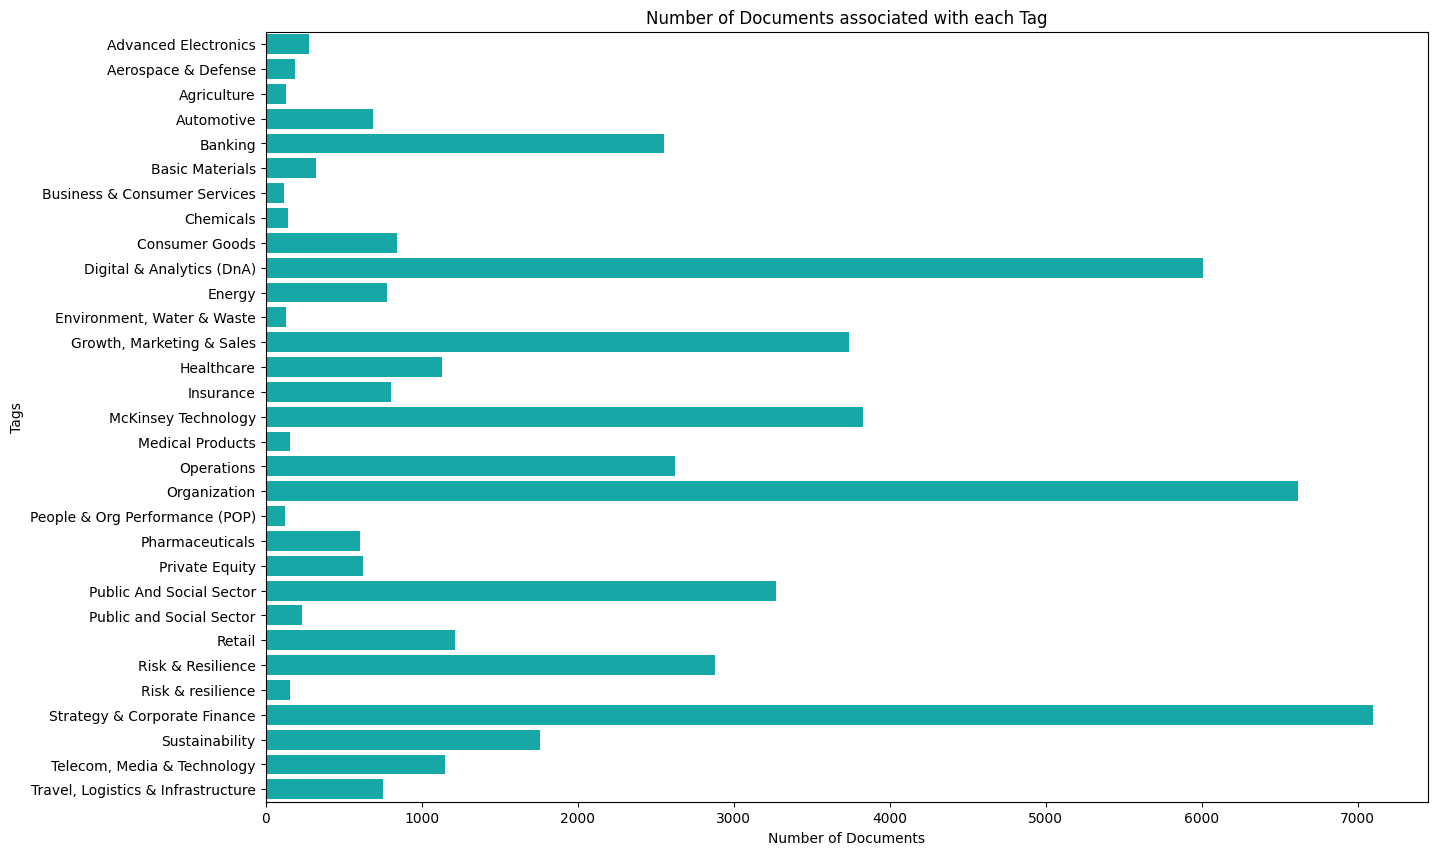

In [19]:
plt.figure(figsize=(15, 10))
sns.barplot(x=tag_counts_.values, y=tag_counts_.index, color="c")
plt.xlabel("Number of Documents")
plt.ylabel("Tags")
plt.title("Number of Documents associated with each Tag")
plt.show()

Text Vectorization


In [20]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words="english")
X_train_tfidf_1 = tfidf.fit_transform(X_train_1)
X_test_tfidf_1 = tfidf.transform(X_test_1)
joblib.dump(tfidf, "tfidfmodel.joblib")
X_train_tfidf_1.shape, X_test_tfidf_1.shape

((18000, 507190), (2000, 507190))

### Model Training


Decision Tree Classifier


In [17]:
from sklearn.tree import DecisionTreeClassifier

DTC_1 = OneVsRestClassifier(DecisionTreeClassifier(criterion="entropy", random_state=0))
dtc1 = DTC_1.fit(X_train_tfidf_1, y_train_1)

Random Forest Classifier


In [18]:
RFC_1 = OneVsRestClassifier(RandomForestClassifier())
rfc1 = RFC_1.fit(X_train_tfidf_1, y_train_1)

Stochastic Gradient Descent Classifier


In [32]:
SGD_1 = OneVsRestClassifier(SGDClassifier())
sgd1 = SGD_1.fit(X_train_tfidf_1, y_train_1)

Logistic Regression


In [33]:
LR_1 = OneVsRestClassifier(LogisticRegression(solver="lbfgs"))
lr1 = LR_1.fit(X_train_tfidf_1, y_train_1)

Support Vector Classifier


In [21]:
SVC_1 = OneVsRestClassifier(LinearSVC())
svc1 = SVC_1.fit(X_train_tfidf_1, y_train_1)
joblib.dump(svc1, "LinearSVC.joblib")

['LinearSVC.joblib']

XGBoost Classifier


In [22]:
XGB_1 = OneVsRestClassifier(XGBClassifier())
xgb1 = XGB_1.fit(X_train_tfidf_1, y_train_1)

Voting Classsifier


In [23]:
log_clf = LogisticRegression(solver="liblinear")
rnd_clf = RandomForestClassifier(n_estimators=100)
xgb_clf = XGBClassifier(n_estimators=100)
svm_clf = SVC(gamma="auto", probability=True)

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf), ("xgb", xgb_clf)],
    voting="soft",
)

ovr_voting_1 = OneVsRestClassifier(voting_clf)
ovr_voting_1.fit(X_train_tfidf_1, y_train_1)  # Make sure to fit it with your train data

OneVsRestClassifier(estimator=VotingClassifier(estimators=[('lr',
                                                            LogisticRegression(solver='liblinear')),
                                                           ('rf',
                                                            RandomForestClassifier()),
                                                           ('svc',
                                                            SVC(gamma='auto',
                                                                probability=True)),
                                                           ('xgb',
                                                            XGBClassifier(base_score=None,
                                                                          booster=None,
                                                                          callbacks=None,
                                                                          colsample_bylevel=None,
                                                                          colsample_bynode=None,
                                                                          colsample_bytree=None,
                                                                          device=None,
                                                                          early_stopping_rounds=None...
                                                                          importance_type=None,
                                                                          interaction_constraints=None,
                                                                          learning_rate=None,
                                                                          max_bin=None,
                                                                          max_cat_threshold=None,
                                                                          max_cat_to_onehot=None,
                                                                          max_delta_step=None,
                                                                          max_depth=None,
                                                                          max_leaves=None,
                                                                          min_child_weight=None,
                                                                          missing=nan,
                                                                          monotone_constraints=None,
                                                                          multi_strategy=None,
                                                                          n_estimators=100,
                                                                          n_jobs=None,
                                                                          num_parallel_tree=None,
                                                                          random_state=None, ...))],
                                               voting='soft'))

In [24]:
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix


def Evaluate_Matrix(y_true, y_pred):
    eva_matrix = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracies = []
    precision = []
    recall = []
    f1 = []
    jaccard = []
    hamming = []

    for y_trues, y_preds in zip(y_true, y_pred):

        pre_mlcm = multilabel_confusion_matrix(y_true, y_pred)

        accuracies.append(accuracy_score(y_trues, y_preds))
        # recall.append(metrics.recall_score(y_trues, y_preds, average="micro"))
        recall.append((pre_mlcm[:, 0, 0] / (pre_mlcm[:, 0, 0] + pre_mlcm[:, 1, 0])))
        precision.append(
            metrics.precision_score(
                y_trues, y_preds, average="weighted", zero_division=0
            )
        )
        jaccard.append(
            jaccard_score(y_trues, y_preds, average="weighted", zero_division=0)
        )
        f1.append(
            metrics.f1_score(y_trues, y_preds, average="weighted", zero_division=0)
        )
        hamming.append(hamming_loss(y_trues, y_preds))

    eva_matrix.append(np.mean(accuracies))
    eva_matrix.append(np.mean(recall))
    eva_matrix.append(np.mean(precision))
    eva_matrix.append(np.mean(jaccard))
    eva_matrix.append(np.mean(f1))
    eva_matrix.append(np.mean(hamming))

    return eva_matrix

In [25]:
models = [
    # ("RandomForest", rfc1),
    # ("DecisionTree", dtc1),
    # ("SGD", sgd1),
    # ("LogisticRegression", lr1),
    ("LinearSVC", svc1),
    # ("XGBoost", xgb1),
    # ("VotingClassifier", ovr_voting_1),
]

model_comparison = {}

for model_name, model in models:
    predictions = model.predict(X_test_tfidf_1)
    matrix = Evaluate_Matrix(y_test_1, predictions)
    model_comparison[model_name] = {
        "Accuracy": matrix[0],
        "Recall/Sensy": matrix[1],
        "Precision": matrix[2],
        "Jaccard Score": matrix[3],
        "F1 Score": matrix[4],
        "Hamming Loss": matrix[5],
    }

    # joblib.dump(model, model_name + ".joblib")

model_scores = pd.DataFrame.from_dict(model_comparison, orient="index")

model_scores

,Accuracy,Recall/Sensy,Precision,Jaccard Score,F1 Score,Hamming Loss
LinearSVC,0.949485,0.956138,0.94636,0.911383,0.942644,0.050515


In [27]:
mlb.classes_

array(['Advanced Electronics', 'Aerospace & Defense', 'Agriculture',
       'Automotive', 'Banking', 'Basic Materials',
       'Business & Consumer Services', 'Chemicals', 'Consumer Goods',
       'Digital & Analytics (DnA)', 'Energy',
       'Environment, Water & Waste', 'Growth, Marketing & Sales',
       'Healthcare', 'Insurance', 'McKinsey Technology',
       'McKinsey Transformation', 'Mckinsey Transformation',
       'Medical Products', 'Operations', 'Ops-Capital Excellence',
       'Organization', 'People & Org Performance (POP)',
       'Pharmaceuticals', 'Private Equity', 'Public And Social Sector',
       'Public and Social Sector', 'Retail', 'Risk & Resilience',
       'Risk & resilience', 'Strategy & Corporate Finance',
       'Sustainability', 'Telecom, Media & Technology',
       'Travel, Logistics & Infrastructure'], dtype=object)

In [26]:
print(
    classification_report(
        y_test_1_,
        predictions,
        output_dict=False,
        zero_division=0,
        target_names=mlb.classes_,
    )
)

ValueError: Multi-label binary indicator input with different numbers of labels

#### Classification


In [37]:
text = [
    "The CFO's role in helping companies navigate the coronavirus crisis - Strong, steady leadership from the finance organization is critical for addressing immediate concerns about safety and survival, stabilizing the business in the near term, and positioning it for recovery."
]
text = pd.Series(text)
text = text.apply(preprocess_text)
text_tfidf = tfidf.transform(text)
predictions = svc1.predict(text_tfidf)
predicted_labels = mlb.inverse_transform(predictions)
predicted_labels

[('Risk & Resilience', 'Strategy & Corporate Finance')]

In [38]:
GEN_PRACTICE_AREA = []

for value in testingDataset["SUMMARY"]:
    text = pd.Series(value)
    text = text.apply(preprocess_text)
    text_tfidf = tfidf.transform(text)
    predictions = svc1.predict(text_tfidf)
    predicted_labels = mlb.inverse_transform(predictions)
    GEN_PRACTICE_AREA.append(predicted_labels)
    print(predicted_labels)
data = {
    "GEN_PRACTICE/AREA": GEN_PRACTICE_AREA,
}
predData = pd.DataFrame(data)

[('Public And Social Sector',)]
[('Public And Social Sector', 'Sustainability')]
[('Consumer Goods', 'Growth, Marketing & Sales', 'Retail')]
[('Healthcare',)]
[('Digital & Analytics (DnA)', 'McKinsey Technology')]
[('Operations',)]
[('Private Equity',)]
[('Banking',)]
[('Risk & Resilience', 'Strategy & Corporate Finance')]
[('Insurance', 'Strategy & Corporate Finance')]
[('Organization',)]
[('Consumer Goods', 'Digital & Analytics (DnA)', 'Growth, Marketing & Sales')]
[('Digital & Analytics (DnA)', 'McKinsey Technology')]
[()]
[('Telecom, Media & Technology',)]
[('Strategy & Corporate Finance',)]
[('Banking', 'Risk & Resilience', 'Strategy & Corporate Finance')]
[('Organization',)]
[('Insurance', 'Risk & Resilience')]
[('Growth, Marketing & Sales', 'Retail', 'Telecom, Media & Technology')]
[('Growth, Marketing & Sales',)]
[('Growth, Marketing & Sales', 'Retail')]
[('Growth, Marketing & Sales',)]
[('Energy', 'Operations', 'Sustainability')]
[('Automotive', 'Growth, Marketing & Sales')]
[

In [39]:
testingDataset = pd.concat([testingDataset, predData], axis=1)
testingDataset.head()
# newDataset2.to_excel("generated_tags.xlsx", index=False)
# x = pd.read_excel('generated_tags.xlsx')
# x.head()

,SUMMARY,PRACTICE/AREA,GEN_PRACTICE/AREA
0,Infrastructure trends - Since the onset of the...,Public And Social Sector|Operations|Sustainabi...,"[(Public And Social Sector,)]"
1,Failure is not an option: Increasing the chanc...,Sustainability|Organization,"[(Public And Social Sector, Sustainability)]"
2,Cautiously optimistic: Chinese consumer behavi...,"Consumer Goods|Growth, Marketing & Sales|Digit...","[(Consumer Goods, Growth, Marketing & Sales, R..."
3,Three ways health insurers can reimagine partn...,Healthcare|Strategy & Corporate Finance|Operat...,"[(Healthcare,)]"
4,Visualizing your journey - The cloud can eat a...,McKinsey Technology|Public And Social Sector|T...,"[(Digital & Analytics (DnA), McKinsey Technolo..."


### 2nd Level Prediction


In [40]:
y_test_2.reset_index(drop=True, inplace=True)
testingDataset = pd.concat([testingDataset, y_test_2], axis=1)
testingDataset.head()

,SUMMARY,PRACTICE/AREA,GEN_PRACTICE/AREA,SL/SUB-AREA
0,Infrastructure trends - Since the onset of the...,Public And Social Sector|Operations|Sustainabi...,"[(Public And Social Sector,)]",Public infrastructure & cities|Capital excelle...
1,Failure is not an option: Increasing the chanc...,Sustainability|Organization,"[(Public And Social Sector, Sustainability)]",Sustainability strategy & portfolio|Decarboniz...
2,Cautiously optimistic: Chinese consumer behavi...,"Consumer Goods|Growth, Marketing & Sales|Digit...","[(Consumer Goods, Growth, Marketing & Sales, R...",Consumer Goods- Other|Marketing strategy- bra...
3,Three ways health insurers can reimagine partn...,Healthcare|Strategy & Corporate Finance|Operat...,"[(Healthcare,)]",Healthcare providers|M&A - S&CF|Manufacturing ...
4,Visualizing your journey - The cloud can eat a...,McKinsey Technology|Public And Social Sector|T...,"[(Digital & Analytics (DnA), McKinsey Technolo...",Data transformation|PSSP- Other|Software|Digit...


In [41]:
y_train_2 = y_train_2.str.split("|")
y_test_2 = y_test_2.str.split("|")

y_train_2.head()

3065     [Corporate & Portfolio Strategy, Crisis Prepar...
2672     [McKinsey Technology- Other, Telecommunication...
14299                [Economic development, Retail- Other]
469      [Corporate & Portfolio Strategy, Talent, Sales...
61       [Future mobility, Customer experience, Automot...
Name: SL/SUB-AREA, dtype: object

In [42]:
mlb2 = MultiLabelBinarizer()
y_train_2 = mlb2.fit_transform(y_train_2)
y_test_2 = mlb2.transform(y_test_2)
y_train_2 = pd.DataFrame(y_train_2, columns=mlb2.classes_)
y_test_2 = pd.DataFrame(y_test_2, columns=mlb2.classes_)
y_train_2.head()

,Accounting services,Advanced Electronics- Other,Advanced materials,Aerospace & Defense- Other,Aerospace aftermarket & services,Aerospace equipment & products,Aftermarket & services,Agricultural inputs,Agricultural produce trading & processing,Agriculture input distribution & service,...,"Travel, Logistics & Infrastructure- Other",Underwriting,Venture Capital,Venture capital,Water,Wealth & asset management,Wealth and asset management,consumer electronics,food,talent
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
joblib.dump(mlb2, "mlb2.joblib")

['mlb2.joblib']

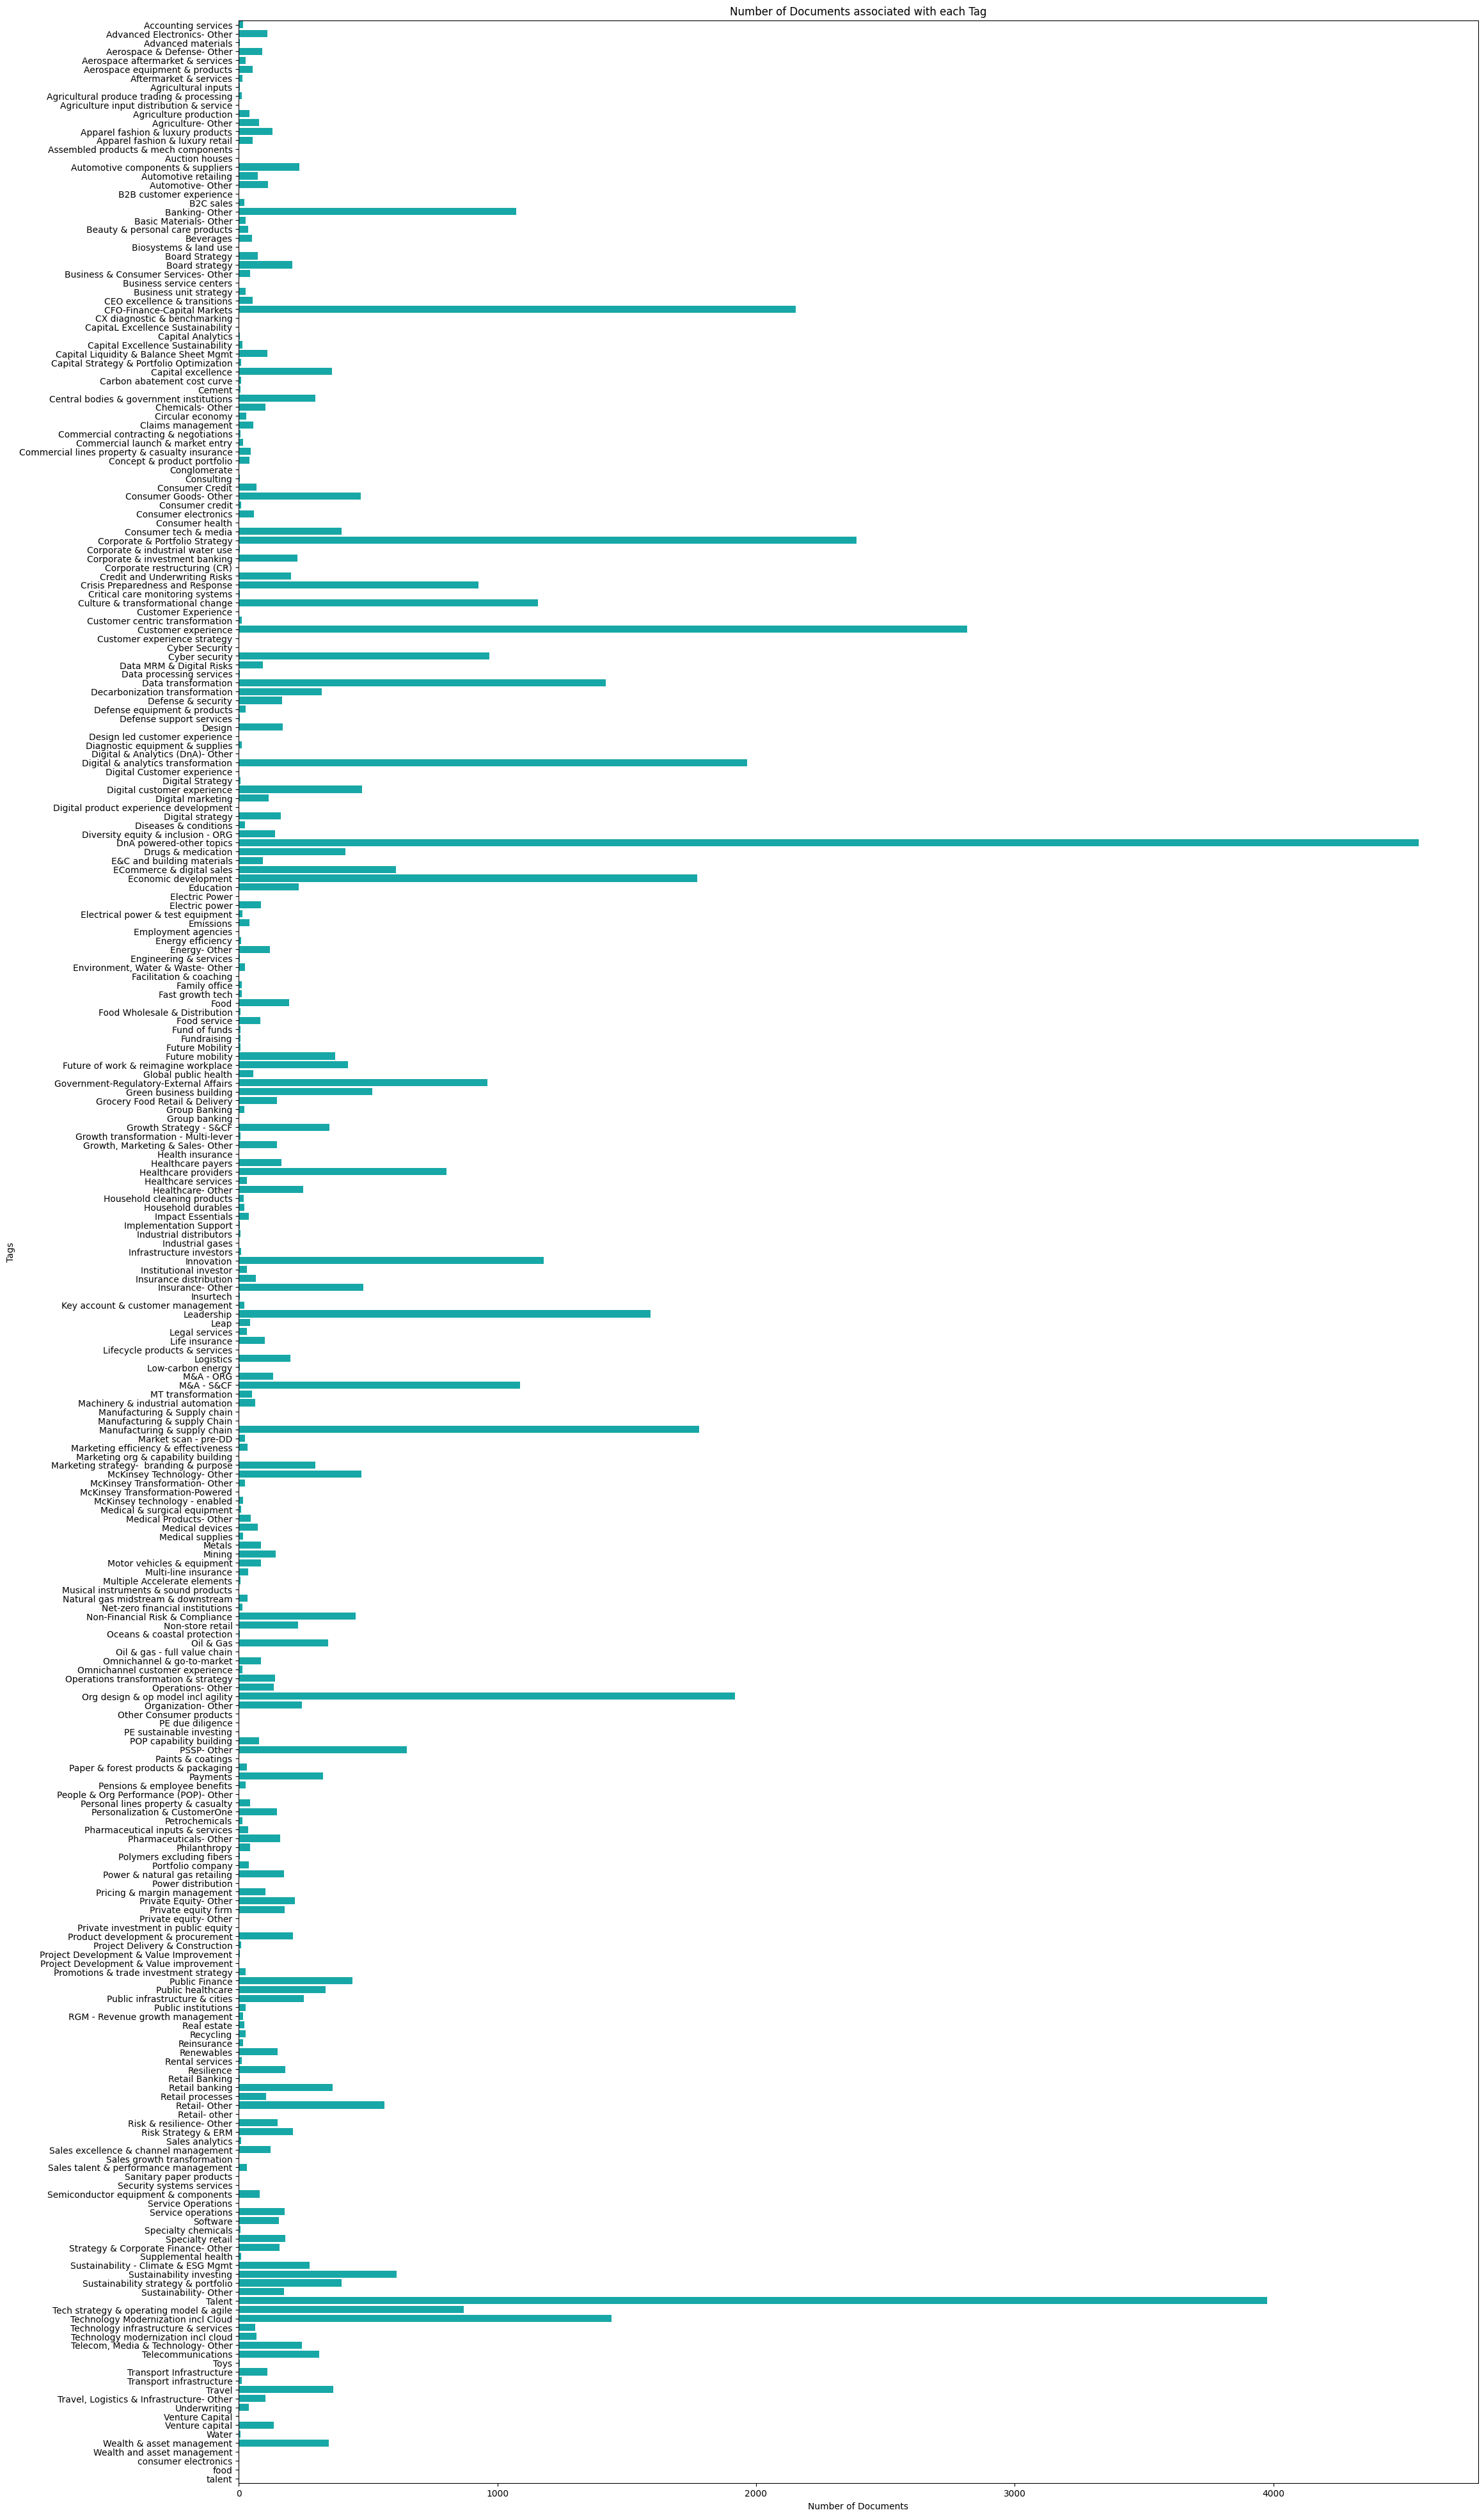

In [44]:
tag_counts = y_train_2.sum(numeric_only=True) + y_test_2.sum(numeric_only=True)

# Plot
plt.figure(figsize=(25, 50))
sns.barplot(x=tag_counts.values, y=tag_counts.index, color="c")
plt.xlabel("Number of Documents")
plt.ylabel("Tags")
plt.title("Number of Documents associated with each Tag")
plt.show()

In [35]:
DTC_2 = OneVsRestClassifier(DecisionTreeClassifier(criterion="entropy", random_state=0))
dtc2 = DTC_2.fit(X_train_tfidf_1, y_train_2)

In [ ]:
RFC_2 = OneVsRestClassifier(RandomForestClassifier())
rfc2 = RFC_2.fit(X_train_tfidf_1, y_train_2)

In [46]:
SGD_2 = OneVsRestClassifier(SGDClassifier())
sgd2 = SGD_2.fit(X_train_tfidf_1, y_train_2)

In [47]:
LR_2 = OneVsRestClassifier(LogisticRegression(solver="lbfgs"))
lr2 = LR_2.fit(X_train_tfidf_1, y_train_2)

In [ ]:
XGB_2 = OneVsRestClassifier(XGBClassifier())
xgb2 = XGB_2.fit(X_train_tfidf_1, y_train_2)

In [48]:
SVC_2 = OneVsRestClassifier(LinearSVC())
svc2 = SVC_2.fit(X_train_tfidf_1, y_train_2)

In [49]:
joblib.dump(svc2, "LinearSVC2.joblib")

['LinearSVC2.joblib']

In [ ]:
log_clf_2 = LogisticRegression(solver="liblinear")
rnd_clf_2 = RandomForestClassifier(n_estimators=100)
xgb_clf_2 = XGBClassifier(n_estimators=100)
svm_clf_2 = SVC(gamma="auto", probability=True)

voting_clf2 = VotingClassifier(
    estimators=[
        ("lr", log_clf_2),
        ("rf", rnd_clf_2),
        ("svc", svm_clf_2),
        ("xgb", xgb_clf_2),
    ],
    voting="soft",
)

ovr_voting_2 = OneVsRestClassifier(voting_clf2)
ovr_voting_2.fit(X_train_tfidf_1, y_train_2)  # Make sure to fit it with your train data

In [50]:
models = [
    # ("RandomForest", rfc2),
    # ("DecisionTree", dtc2),
    ("SGD", sgd2),
    ("LogisticRegression", lr2),
    ("LinearSVC", svc2),
    # ("XGBoost", xgb2),
    # ("VotingClassifier", ovr_voting_2),
]

model_comparison = {}

for model_name, model in models:
    predictions = model.predict(X_test_tfidf_1)
    matrix = Evaluate_Matrix(y_test_2, predictions)
    model_comparison[model_name] = {
        "Accuracy": matrix[0],
        "Recall/Sensy": matrix[1],
        "Precision": matrix[2],
        "Jaccard Score": matrix[3],
        "F1 Score": matrix[4],
        "Hamming Loss": matrix[5],
    }

    # joblib.dump(model, model_name + "2.joblib")

model_scores = pd.DataFrame.from_dict(model_comparison, orient="index")

model_scores

,Accuracy,Recall/Sensy,Precision,Jaccard Score,F1 Score,Hamming Loss
SGD,0.990052,0.990223,0.983570,0.980562,0.986016,0.009948
LogisticRegression,0.989726,0.989877,0.982309,0.979883,0.985373,0.010274
LinearSVC,0.990511,0.991364,0.986670,0.982076,0.987660,0.009489


In [53]:
text = [
    "The CFO's role in helping companies navigate the coronavirus crisis - Strong, steady leadership from the finance organization is critical for addressing immediate concerns about safety and survival, stabilizing the business in the near term, and positioning it for recovery."
]
text = pd.Series(text)
text = text.apply(preprocess_text)
text_tfidf = tfidf.transform(text)
predictions = svc2.predict(text_tfidf)
predicted_labels = mlb2.inverse_transform(predictions)
predicted_labels

[('CFO-Finance-Capital Markets', 'Crisis Preparedness and Response')]

In [54]:
GEN_PRACTICE_AREA = []

for value in testingDataset["SUMMARY"]:
    text = pd.Series(value)
    text = text.apply(preprocess_text)
    text_tfidf = tfidf.transform(text)
    predictions = svc2.predict(text_tfidf)
    predicted_labels = mlb2.inverse_transform(predictions)
    GEN_PRACTICE_AREA.append(predicted_labels)
    print(predicted_labels)
data = {
    "GEN_SL/SUB-AREA": GEN_PRACTICE_AREA,
}
predData = pd.DataFrame(data)

[()]
[('Green business building',)]
[('Customer experience', 'Marketing strategy-  branding & purpose')]
[('Healthcare payers',)]
[('Digital & analytics transformation',)]
[('Manufacturing & supply chain',)]
[('Venture capital',)]
[()]
[('Board strategy',)]
[('Insurance- Other',)]
[()]
[()]
[('Digital & analytics transformation',)]
[('Public infrastructure & cities',)]
[()]
[()]
[('Leadership',)]
[('Talent',)]
[('Cyber security',)]
[()]
[('Customer experience',)]
[('ECommerce & digital sales', 'Non-store retail')]
[('Customer experience',)]
[('DnA powered-other topics', 'Manufacturing & supply chain')]
[('Automotive components & suppliers',)]
[('Education',)]
[('Customer experience', 'Insurance- Other', 'Technology Modernization incl Cloud')]
[()]
[()]
[()]
[('Consumer tech & media', 'Customer experience', 'DnA powered-other topics', 'Telecommunications')]
[('Talent',)]
[()]
[()]
[('Data transformation', 'Digital & analytics transformation', 'DnA powered-other topics', 'Healthcare prov

In [55]:
testingDataset = pd.concat([testingDataset, predData], axis=1)
testingDataset.head()
testingDataset.to_excel("generated_tag_2.xlsx", index=False)
x = pd.read_excel("generated_tags.xlsx")
x.head()

,SUMMARY,PRACTICE/AREA,GEN_PRACTICE/AREA,SL/SUB-AREA,GEN_SL/SUB-AREA
0,Infrastructure trends - Since the onset of the...,Public And Social Sector|Operations|Sustainabi...,"[('Public And Social Sector',)]",Public infrastructure & cities|Capital excelle...,"[('DnA powered-other topics', 'Education', 'He..."
1,Failure is not an option: Increasing the chanc...,Sustainability|Organization,"[('Sustainability',)]",Sustainability strategy & portfolio|Decarboniz...,"[('Economic development', 'Green business buil..."
2,Cautiously optimistic: Chinese consumer behavi...,"Consumer Goods|Growth, Marketing & Sales|Digit...","[('Consumer Goods', 'Growth, Marketing & Sales...",Consumer Goods- Other|Marketing strategy- bra...,"[('ECommerce & digital sales', 'Food', 'Market..."
3,Three ways health insurers can reimagine partn...,Healthcare|Strategy & Corporate Finance|Operat...,"[('Healthcare',)]",Healthcare providers|M&A - S&CF|Manufacturing ...,"[('Healthcare payers',)]"
4,Visualizing your journey - The cloud can eat a...,McKinsey Technology|Public And Social Sector|T...,"[('Digital & Analytics (DnA)', 'McKinsey Techn...",Data transformation|PSSP- Other|Software|Digit...,"[('Government-Regulatory-External Affairs',)]"
